In [1]:
import pickle

with open("X_train.pkl", "rb") as f:
    X_train = pickle.load(f)

with open("X_test.pkl", "rb") as f:
    X_test = pickle.load(f)

with open("y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

with open("y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

print("Train/test sets loaded successfully.")



Train/test sets loaded successfully.


In [25]:
list(X_test.columns)


['Previous Owners',
 'Engine',
 'Doors',
 'Seats',
 'Has_Service_History',
 'Mileage_per_Year',
 'Log_Mileage',
 'Mileage_Delta',
 'Owners_per_Year',
 'Is_Family_Car',
 'Premium_Age',
 'Fuel type_Petrol',
 'Fuel type_Petrol Hybrid',
 'Fuel type_Petrol Plug-in Hybrid',
 'Body type_Convertible',
 'Body type_Coupe',
 'Body type_Estate',
 'Body type_Hatchback',
 'Body type_MPV',
 'Body type_Pickup',
 'Body type_SUV',
 'Body type_Saloon',
 'Gearbox_Manual',
 'Emission Class_Euro 2',
 'Emission Class_Euro 3',
 'Emission Class_Euro 4',
 'Emission Class_Euro 5',
 'Emission Class_Euro 6',
 'Engine_Bin_Medium (1.4–2.0L)',
 'Engine_Bin_Performance (3.0L+)',
 'Engine_Bin_Small (≤1.4L)',
 'Age_Band_10+',
 'Age_Band_3-6',
 'Age_Band_6-10',
 'Brand_Alfa',
 'Brand_Audi',
 'Brand_Bmw',
 'Brand_Chevrolet',
 'Brand_Chrysler',
 'Brand_Citroen',
 'Brand_Dacia',
 'Brand_Daihatsu',
 'Brand_Dodge',
 'Brand_Ds',
 'Brand_Fiat',
 'Brand_Ford',
 'Brand_Honda',
 'Brand_Hyundai',
 'Brand_Infiniti',
 'Brand_Jaguar',

In [2]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

print(X_train.columns[:5])
print(y_train.head())


(2873, 343) (718, 343)
(2873,) (718,)
Index(['Previous Owners', 'Engine', 'Doors', 'Seats', 'Has_Service_History'], dtype='object')
0    9.302920
1    8.004700
2    8.697847
3    8.778788
4    8.516993
Name: Log_Price, dtype: float64


In [3]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=500,      # number of trees
    max_depth=None,        # allow full depth
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


RandomForestRegressor(min_samples_leaf=2, min_samples_split=5, n_estimators=500,
                      n_jobs=-1, random_state=42)

In [4]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

y_pred = rf.predict(X_test)

print("Random Forest Performance:")
print("R²:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


Random Forest Performance:
R²: 0.8582536896392581
MAE: 0.19392389347467823
RMSE: 0.30056772670363235


In [5]:
import pandas as pd

importance = pd.Series(
    rf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

print(importance.head(20))


Emission Class_Euro 6    0.489525
Emission Class_Euro 5    0.112908
Log_Mileage              0.090062
Age_Band_6-10            0.050674
Premium_Age              0.046896
Engine                   0.035818
Age_Band_10+             0.035716
Mileage_Delta            0.018488
Gearbox_Manual           0.017013
Mileage_per_Year         0.014374
Owners_per_Year          0.013642
Brand_Vauxhall           0.007358
Body type_Hatchback      0.006697
Previous Owners          0.003942
Model_Outlander          0.003916
Body type_SUV            0.003843
Brand_Volkswagen         0.003772
Has_Service_History      0.002512
Brand_Peugeot            0.002464
Fuel type_Petrol         0.002418
dtype: float64


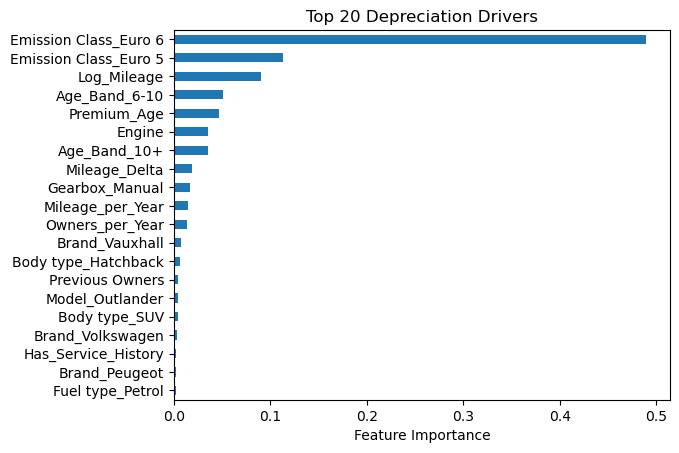

In [6]:
import matplotlib.pyplot as plt

top20 = importance.head(20)

plt.figure()
top20.sort_values().plot(kind="barh")
plt.title("Top 20 Depreciation Drivers")
plt.xlabel("Feature Importance")
plt.show()


In [7]:
actual_price = np.exp(y_test)
predicted_price = np.exp(y_pred)

print("MAE in £:", np.mean(np.abs(actual_price - predicted_price)))


MAE in £: 838.7278613285711


In [8]:
important_features = importance[importance > 0.005]

print(important_features)


Emission Class_Euro 6    0.489525
Emission Class_Euro 5    0.112908
Log_Mileage              0.090062
Age_Band_6-10            0.050674
Premium_Age              0.046896
Engine                   0.035818
Age_Band_10+             0.035716
Mileage_Delta            0.018488
Gearbox_Manual           0.017013
Mileage_per_Year         0.014374
Owners_per_Year          0.013642
Brand_Vauxhall           0.007358
Body type_Hatchback      0.006697
dtype: float64


In [9]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    rf, X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

perm_importance = pd.Series(
    perm.importances_mean,
    index=X_test.columns
).sort_values(ascending=False)

print(perm_importance.head(20))


Emission Class_Euro 6    0.900735
Log_Mileage              0.257406
Emission Class_Euro 5    0.112442
Engine                   0.038253
Premium_Age              0.037386
Age_Band_6-10            0.034742
Mileage_Delta            0.023488
Gearbox_Manual           0.018532
Body type_Hatchback      0.008667
Brand_Vauxhall           0.007315
Brand_Volkswagen         0.005500
Age_Band_10+             0.005407
Mileage_per_Year         0.005070
Body type_SUV            0.004198
Model_Outlander          0.003025
Owners_per_Year          0.002807
Brand_Peugeot            0.002521
Previous Owners          0.001527
Has_Service_History      0.001381
Age_Band_3-6             0.001230
dtype: float64


In [10]:
X_train_rf = X_train.drop(columns=[col for col in X_train.columns if "Emission Class" in col])
X_test_rf = X_test.drop(columns=[col for col in X_test.columns if "Emission Class" in col])


In [11]:
rf.fit(X_train_rf, y_train)

perm = permutation_importance(
    rf, X_test_rf, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

perm_importance = pd.Series(
    perm.importances_mean,
    index=X_test_rf.columns
).sort_values(ascending=False)

print(perm_importance.head(20))


Log_Mileage                 0.524557
Age_Band_10+                0.383929
Mileage_Delta               0.268014
Premium_Age                 0.071114
Age_Band_6-10               0.043471
Engine                      0.031128
Gearbox_Manual              0.019005
Age_Band_3-6                0.010596
Mileage_per_Year            0.008362
Body type_Hatchback         0.008307
Brand_Vauxhall              0.006345
Brand_Volkswagen            0.006285
Body type_SUV               0.005249
Model_Outlander             0.004005
Owners_per_Year             0.003155
Has_Service_History         0.002221
Brand_Peugeot               0.002059
Previous Owners             0.001703
Engine_Bin_Small (≤1.4L)    0.001242
Brand_Mitsubishi            0.000830
dtype: float64


In [12]:
from sklearn.inspection import permutation_importance
import pandas as pd

# Fit your Random Forest regressor
rf.fit(X_train_rf, y_train)

# Use a regression scoring metric, e.g., R^2
perm = permutation_importance(
    rf,
    X_test_rf,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring='r2'  )

# Convert to Series and sort
perm_importance = pd.Series(
    perm.importances_mean,
    index=X_test_rf.columns
).sort_values(ascending=False)

print(perm_importance.head(20))



Log_Mileage                 0.524557
Age_Band_10+                0.383929
Mileage_Delta               0.268014
Premium_Age                 0.071114
Age_Band_6-10               0.043471
Engine                      0.031128
Gearbox_Manual              0.019005
Age_Band_3-6                0.010596
Mileage_per_Year            0.008362
Body type_Hatchback         0.008307
Brand_Vauxhall              0.006345
Brand_Volkswagen            0.006285
Body type_SUV               0.005249
Model_Outlander             0.004005
Owners_per_Year             0.003155
Has_Service_History         0.002221
Brand_Peugeot               0.002059
Previous Owners             0.001703
Engine_Bin_Small (≤1.4L)    0.001242
Brand_Mitsubishi            0.000830
dtype: float64


# Accuracy and Performance

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = rf.predict(X_test_rf)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Root MSE
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R^2: {r2:.3f}")


RMSE: 0.303
MAE: 0.194
R^2: 0.856


## Residuals

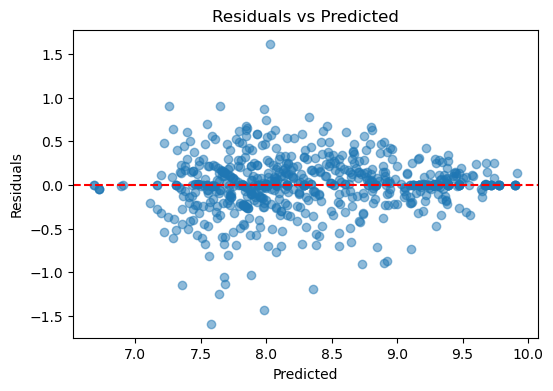

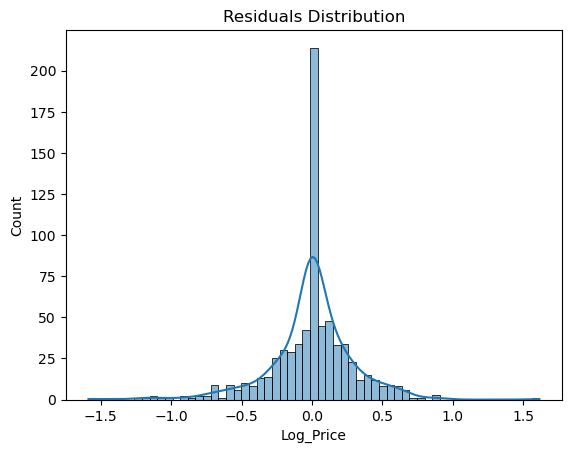

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_test - y_pred

# Residuals vs Predicted
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()

# Residuals distribution
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.show()


## Overfitting Check 

In [15]:
y_train_pred = rf.predict(X_train_rf)

print("Train R²:", r2_score(y_train, y_train_pred))
print("Test R²:", r2_score(y_test, y_pred))


Train R²: 0.9675902725774037
Test R²: 0.8561859611164968


## Pipeline 

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np


# Optional: numeric preprocessing (scale features)
numeric_features = X_train.columns.tolist()
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
)

# Build pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Hyperparameter grid for tuning
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [25, 30, 35 ],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 3, 5],
}

# Grid search
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Train R²:", grid_search.score(X_train, y_train))
print("Test R²:", grid_search.score(X_test, y_test))


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best params: {'regressor__max_depth': 25, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 100}
Train R²: 0.9763567112166446
Test R²: 0.8538700736372766


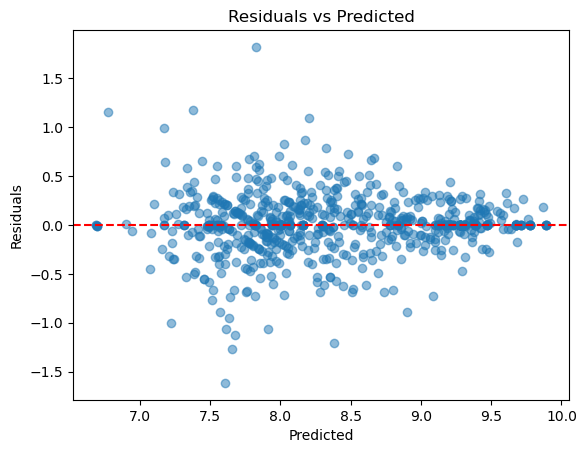

In [17]:
residuals = y_test - grid_search.predict(X_test)

plt.scatter(grid_search.predict(X_test), residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = grid_search.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")


RMSE: 0.31
MAE: 0.20
R²: 0.85


RMSE: 0.31
MAE: 0.20
R²: 0.85


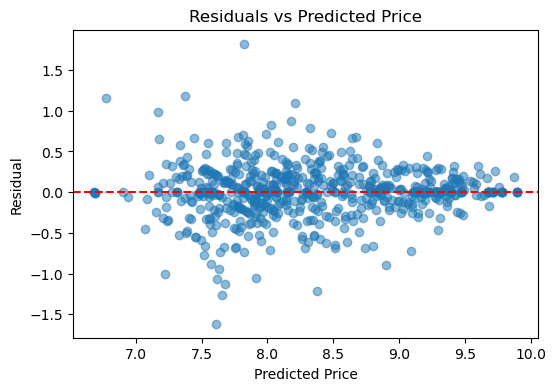

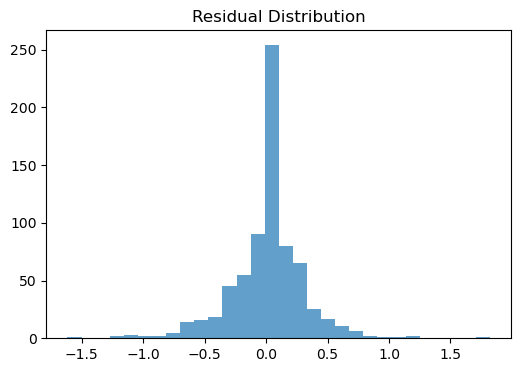

Top 10 features:
 Emission Class_Euro 6    0.875180
Log_Mileage              0.257443
Emission Class_Euro 5    0.110848
Premium_Age              0.036155
Engine                   0.035643
Age_Band_6-10            0.033634
Mileage_Delta            0.023338
Gearbox_Manual           0.019777
Body type_Hatchback      0.008242
Brand_Vauxhall           0.007448
dtype: float64


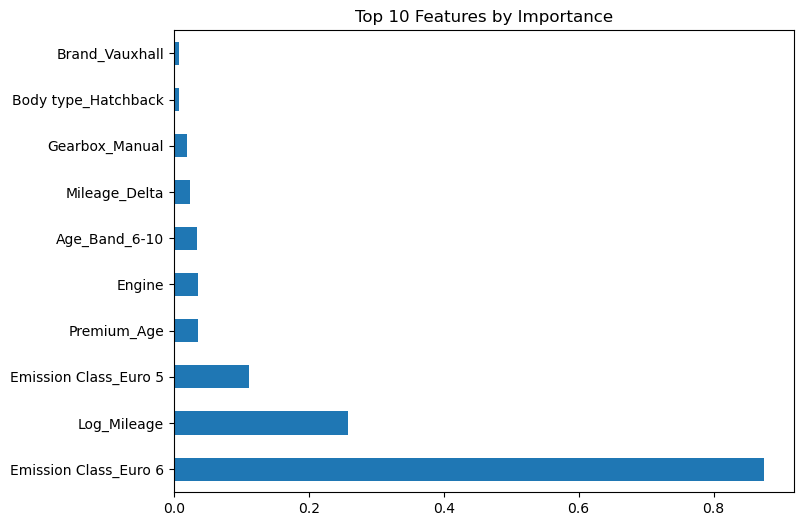


Top 5 undervalued vehicles:
      Previous Owners  Engine  Doors  Seats  Has_Service_History  \
276                4     1.8    4.0    5.0                    0   
199                7     1.5    3.0    4.0                    0   
26                 5     2.2    5.0    7.0                    0   
671                6     2.0    5.0    5.0                    0   
647                3     1.0    5.0    4.0                    0   

     Mileage_per_Year  Log_Mileage  Mileage_Delta  Owners_per_Year  \
276          0.315789     1.791759        -170994         0.210526   
199       8916.666667    11.580584          -1000         0.583333   
26       11090.909091    11.711776          23000         0.454545   
671       6153.846154    11.289782         -37000         0.461538   
647       5944.444444    11.580584         -55000         0.166667   

     Is_Family_Car  ...  Model_Zafira Tourer  Usage_Level_Low  \
276              1  ...                False             True   
199             

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

# 1️⃣ Predict using pipeline/grid search
y_pred = grid_search.predict(X_test)

# 2️⃣ Performance metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

# 3️⃣ Residuals
residuals = y_test - y_pred

plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residual')
plt.title('Residuals vs Predicted Price')
plt.show()

# Optional: histogram of residuals
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, alpha=0.7)
plt.title('Residual Distribution')
plt.show()

# 4️⃣ Feature importance (permutation)
perm = permutation_importance(
    grid_search, X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring='r2'  # regression metric
)

perm_importance = pd.Series(perm.importances_mean, index=X_test.columns).sort_values(ascending=False)

print("Top 10 features:\n", perm_importance.head(10))

# Bar chart
perm_importance.head(10).plot(kind='barh', figsize=(8,6))
plt.title('Top 10 Features by Importance')
plt.show()

# 5️⃣ Identify over/under-valued vehicles
analysis_df = X_test.copy()
analysis_df['Actual'] = y_test
analysis_df['Predicted'] = y_pred
analysis_df['Residual'] = residuals

# Undervalued vehicles (sold higher than predicted)
undervalued = analysis_df[analysis_df['Residual'] > 0].sort_values('Residual', ascending=False)

# Overvalued vehicles (sold lower than predicted)
overvalued = analysis_df[analysis_df['Residual'] < 0].sort_values('Residual')

print("\nTop 5 undervalued vehicles:\n", undervalued.head())
print("\nTop 5 overvalued vehicles:\n", overvalued.head())


In [20]:
import numpy as np

# If y_test and y_pred are in log(price)
y_test_price = np.expm1(y_test)   # inverse of log1p
y_pred_price = np.expm1(y_pred)

# Residuals in price units
residuals_price = y_test_price - y_pred_price


In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse_price = mean_squared_error(y_test_price, y_pred_price, squared=False)
mae_price = mean_absolute_error(y_test_price, y_pred_price)
r2_price = r2_score(y_test_price, y_pred_price)

print(f"RMSE (price units): {rmse_price:.2f}")
print(f"MAE (price units): {mae_price:.2f}")
print(f"R²: {r2_price:.2f}")


RMSE (price units): 1427.46
MAE (price units): 845.95
R²: 0.90


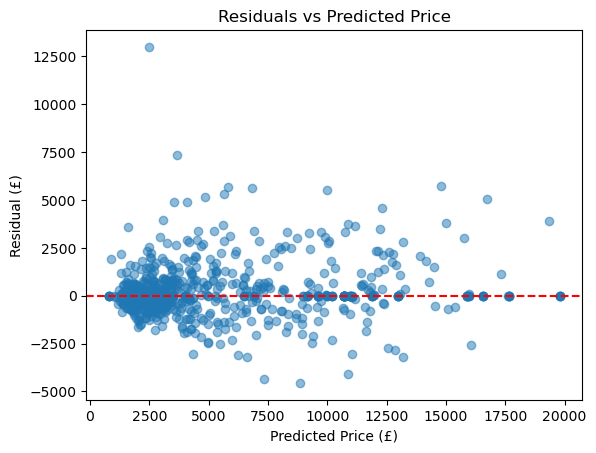

In [22]:
import matplotlib.pyplot as plt

plt.scatter(y_pred_price, residuals_price, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Price (£)')
plt.ylabel('Residual (£)')
plt.title('Residuals vs Predicted Price')
plt.show()


In [23]:
import joblib

# Save trained pipeline or grid search
joblib.dump(grid_search, "vehicle_rf_model.pkl")


['vehicle_rf_model.pkl']

In [26]:
import joblib

# Save the raw model
joblib.dump(rf, "vehicle_rf_model_raw.pkl")


['vehicle_rf_model_raw.pkl']